In [2]:
import yaml
import munch
import warnings

import xarray as xr
import pandas as pd
import copernicusmarine 

from loguru import logger
from tqdm.dask import TqdmCallback

In [3]:
# loading info about our gridded datasets 
catalog = munch.munchify(
    yaml.load(
        stream=open('../data/data_sources.yaml'), 
        Loader=yaml.FullLoader)
)

# Gridded datasets from CMEMS

A data provider for gridded ocean datasets: https://data.marine.copernicus.eu/products

This section also provides a gentle intro to `xarray`. 

In [6]:
# you can choose either of the following dataset_ids
dataset_id = "cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D"  # for chlorophyll data
dataset_id = catalog.ssh_duacs_cmems.url  # for sea surface height data

with warnings.catch_warnings():  # a UserWarning is raised by xarray - we'll safely ignore this
    warnings.simplefilter("ignore")
    logger.info(f"Opening dataset  {dataset_id}")

    ds = copernicusmarine.open_dataset(  # this simply loads a `zarr` file formatted for `xarray`
        dataset_id=dataset_id,  # the url/dataset_id of datasets in the catalog
    )

ds

2025-02-26 15:01:45.841 | INFO     | __main__:<module>:7 - Opening dataset  cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D
INFO - 2025-02-26T14:01:46Z - Selected dataset version: "202411"
INFO - 2025-02-26T14:01:46Z - Selected dataset part: "default"
INFO - 2025-02-26T14:01:48Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username:Copernicus Marine password:

<xarray.Dataset> Size: 4TB
Dimensions:         (time: 11322, latitude: 1440, longitude: 2880, nv: 2)
Coordinates:
    lat_bnds        (latitude, nv) float32 12kB dask.array<chunksize=(1024, 2), meta=np.ndarray>
  * latitude        (latitude) float32 6kB -89.94 -89.81 -89.69 ... 89.81 89.94
    lon_bnds        (longitude, nv) float32 23kB dask.array<chunksize=(1024, 2), meta=np.ndarray>
  * longitude       (longitude) float32 12kB -179.9 -179.8 ... 179.8 179.9
  * nv              (nv) int32 8B 0 1
  * time            (time) datetime64[ns] 91kB 1993-01-01 ... 2023-12-31
Data variables:
    adt             (time, latitude, longitude) float64 376GB dask.array<chunksize=(50, 1024, 1024), meta=np.ndarray>
    err_sla         (time, latitude, longitude) float64 376GB dask.array<chunksize=(50, 1024, 1024), meta=np.ndarray>
    err_ugosa       (time, latitude, longitude) float64 376GB dask.array<chunksize=(50, 1024, 1024), meta=np.ndarray>
    err_vgosa       (time, latitude, longitude) float64 376GB dask.array<chunksize=(50, 1024, 1024), meta=np.ndarray>
    flag_ice        (time, latitude, longitude) float64 376GB dask.array<chunksize=(50, 1024, 1024), meta=np.ndarray>
    sla             (time, latitude, longitude) float64 376GB dask.array<chunksize=(50, 1024, 1024), meta=np.ndarray>
    tpa_correction  (time) float64 91kB dask.array<chunksize=(50,), meta=np.ndarray>
    ugos            (time, latitude, longitude) float64 376GB dask.array<chunksize=(50, 1024, 1024), meta=np.ndarray>
    ugosa           (time, latitude, longitude) float64 376GB dask.array<chunksize=(50, 1024, 1024), meta=np.ndarray>
    vgos            (time, latitude, longitude) float64 376GB dask.array<chunksize=(50, 1024, 1024), meta=np.ndarray>
    vgosa           (time, latitude, longitude) float64 376GB dask.array<chunksize=(50, 1024, 1024), meta=np.ndarray>
Attributes:
    comment:      Sea Surface Height measured by Altimetry and derived variables
    source:       Altimetry measurements
    Conventions:  CF-1.6
    institution:  CLS, CNES
    references:   http://marine.copernicus.eu
    history:      2024-10-23 12:55:06Z: Creation
    contact:      servicedesk.cmems@mercator-ocean.eu
    title:        DT merged all satellites Global Ocean Gridded SSALTO/DUACS ...

## Notes about `xarray` 

The `xarray` library is a powerful tool for working with gridded datasets. It is built on top of `numpy` and `pandas` and supports parallel computation using `dask`.  

### Structure of an `xarray.Dataset`
An `xarray.Dataset` is a collection of `xarray.DataArray` objects. Each `DataArray` is a labeled, multi-dimensional array with metadata. It is helpful to think of this structure as a `pandas.DataFrame` and `pandas.Series`. 
Each `DataArray` has the following attributes:
- `values`: a `numpy` array that contains the data
- `dims`: the names of the dimensions
- `index`: the values of the dimensions (uses `pandas.Index`)
- `coords`: a dictionary of coordinate arrays that can be the same as the dimensions but can also contain metadata
- `attrs`: a dictionary of attributes that can be used to store metadata

### Metadata
`xarray` is built around the idea of a `DataArray`, which is a labeled, multi-dimensional array. It is basically a `numpy` array, but with added metadata. This metadata includes information about the dimensions, coordinates, and attributes of the data. The inspiration for this structure comes from the `netCDF` file format, which is commonly used in the geosciences – we'll look at this format further down. 

### Chunking with `dask`
This allows for efficient computation on large datasets that do not fit into memory, but it does have its quirks. Datasets can be divided in chunks along each dimension, and operations are lazily evaluated. This means that you can build up a computation graph and then evaluate it all at once. It is helpeful to think of these chunks as individual files that are loaded into memory only when needed (zarr makes this very explicit). So, if I load only a section of a dataset, only the chunks that are needed are loaded into memory. 

Here's the quirk: if the original chunk size is the entire dataset, then the entire dataset is loaded into memory, even if you only want a small section of it. Unfortunately, rechunking the data means that you first have to load the data into memory, and then write it back out to disk. 

In [8]:
da = (
    ds.sla  # select the sea level anomaly variable
    .sel(
        time='2023-12-13',  # select a specific time - inclusive notation if using slices
        # time='2023-12',  # this will select all days in December 2023 - same principle applies to months, days, hours
        # time=slice('2023-12-13', '2023-12-15'),  # select a range of time steps - inclusive for date slices
        latitude=slice(-80, 80),  # exclusive notation if using slices for float/integer values
        longitude=slice(-110, 35),  # note that lon is -180 : 180 - selecting Atlantic
    )
    # .mean(dim='time')  # calculate the mean over the time dimension - time dimension is dropped
)

da

<xarray.DataArray 'sla' (latitude: 1280, longitude: 1160)> Size: 12MB
dask.array<getitem, shape=(1280, 1160), dtype=float64, chunksize=(944, 696), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 5kB -79.94 -79.81 -79.69 ... 79.69 79.81 79.94
  * longitude  (longitude) float32 5kB -109.9 -109.8 -109.7 ... 34.81 34.94
    time       datetime64[ns] 8B 2023-12-13
Attributes:
    ancillary_variables:  err_sla
    comment:              The sea level anomaly is the sea surface height abo...
    grid_mapping:         crs
    long_name:            Sea level anomaly
    standard_name:        sea_surface_height_above_sea_level
    units:                m

##  Intro to xarray plotting API

In [9]:
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from cartopy import feature as cfeature
from cmocean import cm as cmo  # registers the cmocean colormaps to matplotlib

c:\Users\henry\miniconda3\envs\isc\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


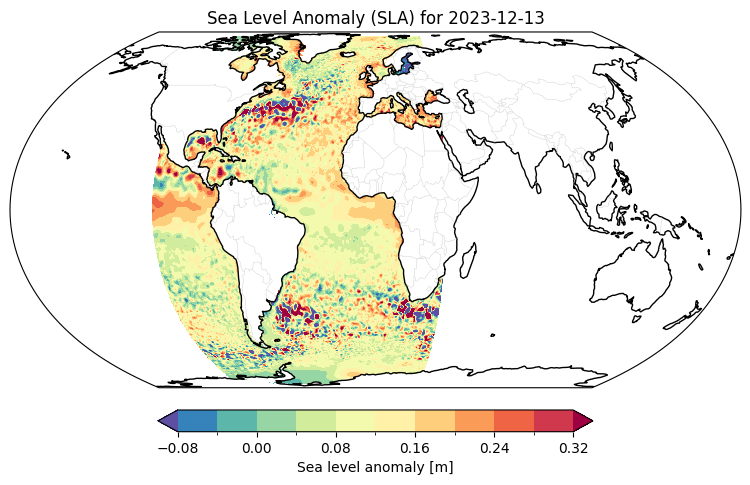

In [23]:
fig, ax = plt.subplots(
    figsize=(9, 5), 
    subplot_kw=dict(
        projection=ccrs.EqualEarth()  # the map projection we want to use
    ), 
    dpi=100)

img = (
    da
    .plot.imshow(  # the xarray.DataArray matplotlib API has [imshow, pcolormesh, contour, contourf] methods
        ax=ax,  # plot on the axis we created
        transform=ccrs.PlateCarree(),  # required to transform the data to the map projection (always PlateCarree)
        cmap='Spectral_r',
        levels=11,  # create discrete colorbar (not the same as contourf)
        center=False,  # if true, the colormap is centered on zero
        cbar_kwargs=dict(  # colorbar keyword arguments
            # label='Custom label for SLA [m]',  # we can set the label, but by default will use `da.attrs.long_name [da.attrs.units]` 
            location='bottom', 
            shrink=0.5,  # reduce the colorbar size to fit our plot
            pad=0.05),
        robust=True,  # this will set the colormap limits to the 2nd and 98th percentiles
    )
)

ax.coastlines(lw=1)  # axes with cartopy projection have a coastlines method
ax.add_feature(cfeature.BORDERS.with_scale('110m'), edgecolor='0.8', linewidth=0.3)
ax.set_title(f'Sea Level Anomaly (SLA) for {pd.Timestamp(da.time.values):%Y-%m-%d}')

fig.tight_layout()

# HTTPS netCDF files

xarray can also download files directly from the URL, meaning we don't always have to donwload the entire file. 

### SST dataset

In [11]:
url_sst = catalog.sst_cci_cdr_B.url.split('::')[1]  # remove the fsspec-based protocol (filecache) from the url - i use this to download the data to disk first
url_sst

'https://dap.ceda.ac.uk/neodc/eocis/data/global_and_regional/sea_surface_temperature/CDR_v3/Analysis/L4/v3.0.1/{t:%Y}/{t:%m}/{t:%d}/{t:%Y%m%d}120000-ESACCI-L4_GHRSST-SSTdepth-OSTIA-GLOB_ICDR3.0-v02.0-fv01.0.nc'

In [12]:
time = pd.Timestamp('2023-12-13')

ds = xr.open_dataset(
    url_sst.format(t=time),  # use datetime formatting in the url 
    chunks={},  # make sure to use dask + native chunk sizes
    engine='h5netcdf',  # specifies backend - h5netcdf allows for reading urls (downloads only metadata/headers)
)

In [26]:
da_sst = (
    ds.analysed_sst  # select sea surface temperature 
    .isel(time=0)  # select the first time step (index-based selection)
    .compute()  # up until now, we've only downloaded the metadata / headers - compute downloads the data
)
da_sst

<xarray.DataArray 'analysed_sst' (lat: 3600, lon: 7200)> Size: 104MB
array([[   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       ...,
       [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
       [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
       [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35]],
      dtype=float32)
Coordinates:
    time     datetime64[ns] 8B 2023-12-13T12:00:00
  * lat      (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.88 89.93 89.97
  * lon      (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Attributes:
    long_name:            analysed sea surface temperature
    standard_name:        sea_water_temperature
    units:                kelvin
    valid_min:            -300
    valid_max:            4500
    actual_range:         [271.15    305.72998]
    source:               AVHRRMTB-UKEOCIS-L3U-ICDR-v3.0, SLSTRA-UKEOCIS-L3U-...
    depth:                20 cm
    ancillary_variables:  analysed_sst_uncertainty mask

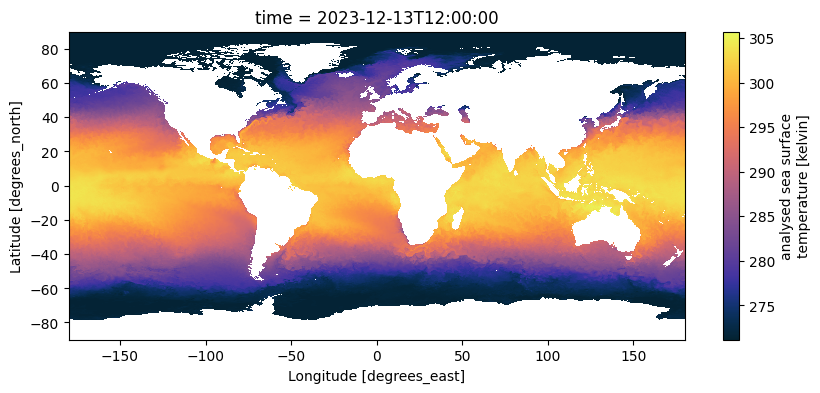

In [14]:
img = da_sst.plot.imshow(
    aspect=2.5,  # our image has a 2 x 1 aspect, but leave space for colorbar 
    size=4,  # sets the image height
    cmap='cmo.thermal'  # cmocean is a cmap library for oceanographic data - when imported cmaps are registered to matplotlib under cmo.<name>
)

img.axes.set_aspect('equal')  # ensures that pixels are square 

### SODA dataset

In [24]:
soda = catalog.soda
vars = soda.variables  # a dictionary of old_name: new_name variables
print(soda.url)
url_soda = soda.url.split('::')[1]  # remove the fsspec-based protocol (filecache) from the url
print(url_soda)
time = pd.Timestamp('2023-12-13')
print(url_soda.format(t=time))

filecache::http://dsrs.atmos.umd.edu/DATA/soda3.15.2/REGRIDED/ocean/soda3.15.2_5dy_ocean_reg_{t:%Y_%m_%d}.nc
http://dsrs.atmos.umd.edu/DATA/soda3.15.2/REGRIDED/ocean/soda3.15.2_5dy_ocean_reg_{t:%Y_%m_%d}.nc
http://dsrs.atmos.umd.edu/DATA/soda3.15.2/REGRIDED/ocean/soda3.15.2_5dy_ocean_reg_2023_12_13.nc


In [25]:
time = pd.Timestamp('2023-12-13')

# while this doesnt load the full dataset, it still has to download 100+ MB of data... quite expensive but no way around this
ds_all = xr.open_dataset(
    url_soda.format(t=time),  # use datetime formatting in the url 
    chunks={},  # make sure to use dask + native chunk sizes
    engine='h5netcdf',  # specifies backend - h5netcdf allows for reading urls (downloads only metadata/headers)
) 
print('done')

ds_surface = (
    ds_all
    [list(vars)]  # select only the variables we're interested in - based on catalog
    .rename(vars)  # rename the variables to the new names 
    .sel(depth=0, method='nearest')  # select the surface level
)

with TqdmCallback():  # shows a progress bar for the download - now we don't have to download much data
    ds_soda = ds_surface.compute()

done


  0%|          | 0/6 [00:00<?, ?it/s]

In [19]:
# dataset has much lower resolution - 0.5 degrees (1/10th that of SST)
ds_soda

<xarray.Dataset> Size: 3MB
Dimensions:        (time: 1, lat: 330, lon: 720)
Coordinates:
  * lon            (lon) float64 6kB 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
  * lat            (lat) float64 3kB -74.75 -74.25 -73.75 ... 88.75 89.25 89.75
    depth          float64 8B 5.034
  * time           (time) datetime64[ns] 8B 2023-12-13T13:00:00
Data variables:
    temp_soda      (time, lat, lon) float32 950kB nan nan nan ... -1.638 -1.638
    salt_soda      (time, lat, lon) float32 950kB nan nan nan ... 30.49 30.49
    mld_dens_soda  (time, lat, lon) float32 950kB nan nan nan ... 49.2 49.21
Attributes:
    CDI:                        Climate Data Interface version 2.3.0 (https:/...
    Conventions:                CF-1.6
    filename:                   soda3.15.2_5dy_ocean_or_2023_12_13.nc
    title:                      MOM5_SODA_3.15.2
    grid_type:                  mosaic
    grid_tile:                  1
    NCO:                        netCDF Operators version 5.1.9 (Homepage = ht...
    history_of_appended_files:  Wed Jul  3 09:00:46 2024: Appended file dum_a...
    code_version:               $Name: siena_201205_z1l $
    CDO:                        Climate Data Operators version 2.3.0 (https:/...
    cdo_openmp_thread_number:   36
    history:                    Wed Jul  3 09:12:04 2024: ncatted -H -a Quant...

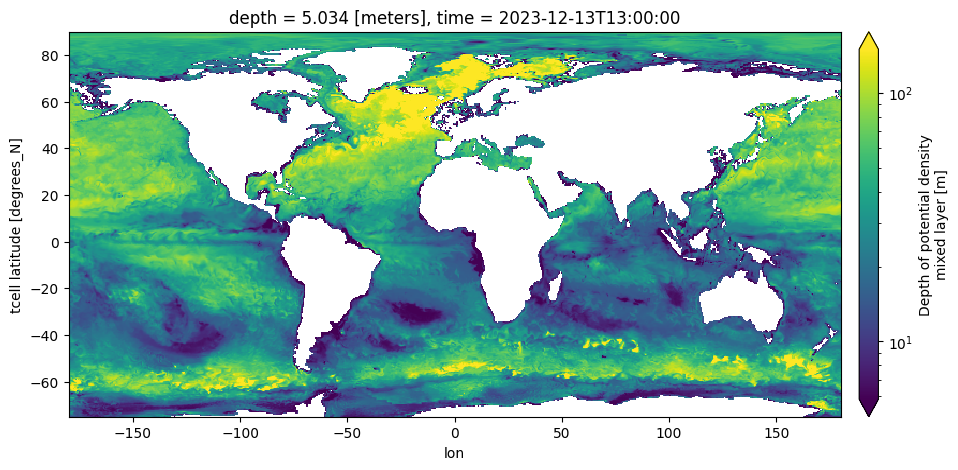

In [20]:
da_mld = (
    ds_soda.mld_dens_soda[0]  # mixed layer depth is the upper "boundary layer" of the ocean where the temperature is well mixed and has similar density
    .assign_coords(lon=lambda x: (x.lon - 180) % 360 - 180)  # convert lon to -180 : 180 format - comment to see difference
    .sortby('lon')  # sort the longitudes
)  

props_mld = dict(
    norm=plt.matplotlib.colors.LogNorm(),  # use a log scale for the colorbar
    robust=True,
    aspect=2.4, size=5,
    cbar_kwargs=dict(pad=0.02))
da_mld.plot.imshow(**props_mld)

## Interpolating dataset to higher resolution

In [14]:
da_3600x7200 = da_mld.interp_like(da_sst)  # does basic bilinear interpolation - lazy operation
# for more advanced interpolation, also see xesmf https://xesmf.readthedocs.io/en/latest/ where weights can be saved for faster interpolation

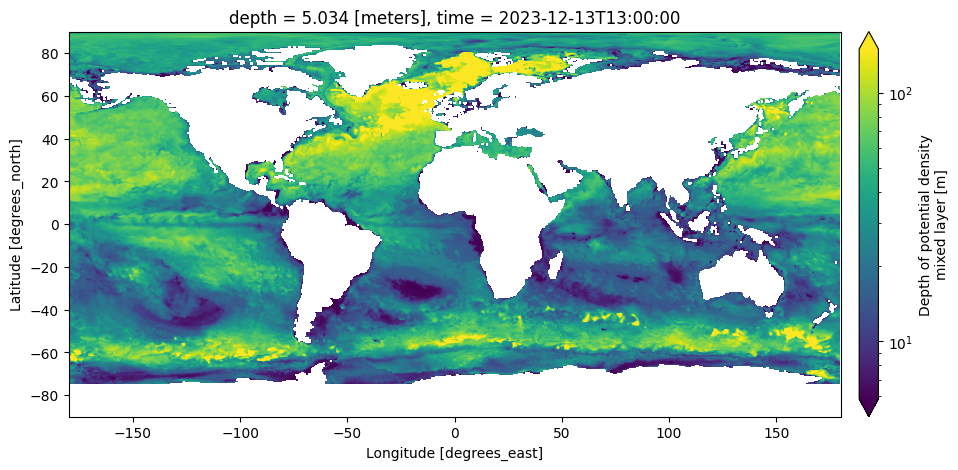

In [15]:
img = (
    da_3600x7200
    .load()  # load is similar to compute, but inplace operation, so downloads once and then downloaded for whole session - not good for memory optimization
    .plot.imshow(**props_mld))